# Reinforcement learning: playing pong

A neuronal network is trained to play pong via reinforcement learning. We use the interface by OpenAI Gym, https://gym.openai.com/.



The code is based on http://karpathy.github.io/2016/05/31/rl/
and the associated code https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5, and on https://github.com/mrahtz/tensorflow-rl-pong/blob/master/pong.py.

# Install dependencies

In [0]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (41.0.1)


# Imports and Helper functions


In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
#  mp4list = glob.glob('./content/drive/My Drive/video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
 # env = Monitor(env, './content/drive/My Drive/video', force=True)

  return env

W0708 14:29:47.440791 139892835153792 abstractdisplay.py:151] xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


# Display a game 

In [0]:
env = wrap_env(gym.make("Pong-v0"))

observation = env.reset()

# We play one 'epsiode', i.e. we play so many games until one player won 21 times.
while True:
  
    env.render()
    
    #we use a random action
    action = env.action_space.sample() 
         
    observation, reward, episode_done, info = env.step(action)   
        
    if episode_done: 
      break;
            
env.close()
show_video()

# Preprocessing of the observations (images)

Observation from the game:



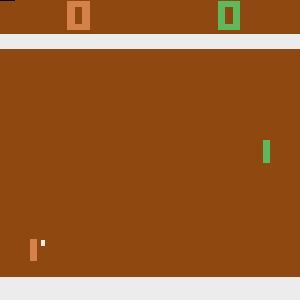



Preprocessed observation:



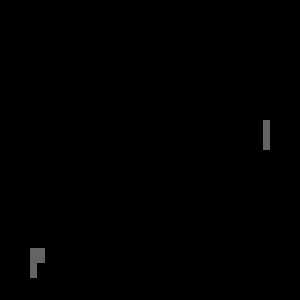



Difference of consecutive preprocessed observations:



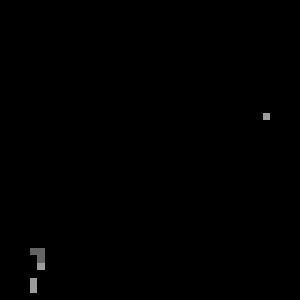

In [0]:
import IPython
from PIL import Image
import gym
import numpy as np
import skimage.measure



## function used to preprocess the image
def myprepro(I):
    I = I[35:195]  # crop
    I = I[::2, ::2, 0]  # downsample by factor of 2, remove the second and third RGB value
    I[I == 144] = 0  # erase background (background type 1)
    I[I == 109] = 0  # erase background (background type 2)
    I[I != 0] = 100  # everything else (paddles, ball) just set to 1. For this visualization we use 100. 
    I = skimage.measure.block_reduce(I, (2,2), np.max) # max pooling
    return I
  
env = gym.make('Pong-v0')

# Action values to send to gym environment to move paddle up/down
UP_ACTION = 2
DOWN_ACTION = 3
action = 2  # No action = 0

# Play until the ball moves into the middle of the field.
env.reset()
for j in range(40):
    o,_,_,_ = env.step(0)

o1,_,_,_ = env.step(0)
o2,_,_,_ = env.step(3)

# The training will use differences of images.
o=o2-o1

print('Observation from the game:\n')
IPython.display.display(
        Image.fromarray(
            o2
       ).resize((300, 300))
    )
print('\n')

o2 = myprepro(o2)
print('Preprocessed observation:\n')
IPython.display.display(
        Image.fromarray(
            o2
       ).resize((300, 300))
    )
print('\n')

o = o2 - myprepro(o1)
print('Difference of consecutive preprocessed observations:\n')
IPython.display.display(
        Image.fromarray(
            o
       ).resize((300, 300))
    )

env.close()



# Training a neuronal net with reinforcement learning

In [0]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jul  6 01:37:16 2019

@author: sebma
"""

import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import skimage.measure

from __future__ import print_function
import os.path
import numpy as np
import tensorflow as tf
import pickle


OBSERVATIONS_SIZE = 6400

class Network:
    def __init__(self, learning_rate, checkpoints_dir):
        self.learning_rate = learning_rate

        self.sess = tf.InteractiveSession()

        self.observations = tf.placeholder(tf.float32,
                                           [None, 1600])
        # +1 for up, -1 for down
        self.sampled_actions = tf.placeholder(tf.float32, [None, 1])
        self.advantage = tf.placeholder(tf.float32, [None, 1], name='advantage')
        
        
        image_size = tf.reshape(self.observations, [-1, 40,40,1])
        conv1 = tf.layers.conv2d(
            inputs=image_size,
            filters=16,
            kernel_size=[4, 4],
            padding="same",
            activation=tf.nn.relu)

  # Pooling Layer #1
    #    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)


  # Dense Layer
        pool1_flat = tf.reshape(conv1, [-1, 40*40*16]) # <-- 80*80 -> 20*20*8 if 8 filters, 20 = (80/2)/2 , 2 times max pooling
       

        h = tf.layers.dense(
            inputs = pool1_flat,
            units=200,
            activation=tf.nn.relu,
            kernel_initializer=tf.contrib.layers.xavier_initializer())
       # dropout = tf.layers.dropout(inputs=h, rate=0.4)
        h2 = tf.layers.dense(
            inputs = self.observations, 
            units=300,
            activation=tf.nn.relu,
            kernel_initializer=tf.contrib.layers.xavier_initializer())
        h3 = tf.layers.dense(
            inputs = h2, 
            units=200,
            activation=tf.nn.relu,
            kernel_initializer=tf.contrib.layers.xavier_initializer())
        self.up_probability = tf.layers.dense(
            inputs = h3,
            units=1,
            activation=tf.sigmoid,
            kernel_initializer=tf.contrib.layers.xavier_initializer())

        # Train based on the log probability of the sampled action.
        # 
        # The idea is to encourage actions taken in rounds where the agent won,
        # and discourage actions in rounds where the agent lost.
        # More specifically, we want to increase the log probability of winning
        # actions, and decrease the log probability of losing actions.
        #
        # Which direction to push the log probability in is controlled by
        # 'advantage', which is the reward for each action in each round.
        # Positive reward pushes the log probability of chosen action up;
        # negative reward pushes the log probability of the chosen action down.
        
        self.loss = tf.losses.log_loss(
            labels=self.sampled_actions,
            predictions=self.up_probability,
            weights=self.advantage)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = optimizer.minimize(self.loss)

        tf.global_variables_initializer().run()

        self.saver = tf.train.Saver()
        self.checkpoint_file = os.path.join(checkpoints_dir,
                                            'policy_network.ckpt')

    def load_checkpoint(self):
        print("Loading checkpoint...")
        self.saver.restore(self.sess, self.checkpoint_file)

    def save_checkpoint(self):
        print("Saving checkpoint...")
        self.saver.save(self.sess, self.checkpoint_file)

    def forward_pass(self, observations):
        up_probability = self.sess.run(
            self.up_probability,
          #  feed_dict={self.observations: observations.reshape([1, -1])})
            feed_dict={self.observations: observations.reshape([-1,1600])})
        return up_probability

#    def train(self, state_action_reward_tuples):
#        print("Training with %d (state, action, reward) tuples" %
#              len(state_action_reward_tuples))
#
#        states, actions, rewards = zip(*state_action_reward_tuples)
#        states = np.vstack(states)
#        actions = np.vstack(actions)
#        rewards = np.vstack(rewards)
#
#        feed_dict = {
#            self.observations: states,
#            self.sampled_actions: actions,
#            self.advantage: rewards
#        }
#        self.sess.run(self.train_op, feed_dict)
    def train(self, states, actions, rewards):
        print("Training with %d (state, action, reward) tuples" %
              len(states))


        feed_dict = {
            self.observations: states.reshape([-1, 1600]),
            self.sampled_actions: actions.reshape([-1, 1]),
            self.advantage: rewards.reshape([-1, 1])
        }
        self.sess.run(self.train_op, feed_dict)


#!/usr/bin/env python
"""
Train a Pong AI using policy gradient-based reinforcement learning.
Based on Andrej Karpathy's "Deep Reinforcement Learning: Pong from Pixels"
http://karpathy.github.io/2016/05/31/rl/
and the associated code
# https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5
"""


#import argparse
#parser = argparse.ArgumentParser()
#parser.add_argument('--hidden_layer_size', type=int, default=200)
#parser.add_argument('--learning_rate', type=float, default=0.0005)
#parser.add_argument('--batch_size_episodes', type=int, default=1)
#parser.add_argument('--checkpoint_every_n_episodes', type=int, default=10)
#parser.add_argument('--load_checkpoint', action='store_true')
#parser.add_argument('--discount_factor', type=int, default=0.99)
#parser.add_argument('--render', action='store_true')
#args = parser.parse_args()


checkpoint_every_n_episodes = 400
learning_rate = 0.0001
end_count=10 # number of episodes for training
last_pictures = []


# Action values to send to gym environment to move paddle up/down
UP_ACTION = 2
DOWN_ACTION = 3
# Mapping from action values to outputs from the policy network
action_dict = {DOWN_ACTION: 0, UP_ACTION: 1}


# From Andrej's code
def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195]  # crop
    I = I[::2, ::2, 0]  # downsample by factor of 2
    I[I == 144] = 0  # erase background (background type 1)
    I[I == 109] = 0  # erase background (background type 2)
    I[I != 0] = 1  # everything else (paddles, ball) just set to 1
    I = skimage.measure.block_reduce(I, (2,2), np.max) # max pooling
    return I.astype(np.float).ravel()
  #  return I.astype(np.float)


def discount_rewards(rewards, discount_factor):
    discounted_rewards = np.zeros_like(rewards)
    for t in range(len(rewards)):
        discounted_reward_sum = 0
        discount = 1
        for k in range(t, len(rewards)):
            discounted_reward_sum += rewards[k] * discount
            discount *= discount_factor
            if rewards[k] != 0:
                # Don't count rewards from subsequent rounds
                break
        discounted_rewards[t] = discounted_reward_sum
    return discounted_rewards

#env = gym.make('Pong-v0')

env = wrap_env(gym.make("Pong-v0"))


network = Network(learning_rate, checkpoints_dir='checkpoints')
if False:
    network.load_checkpoint()

batch_state_action_reward_tuples = []
batch_states = []
batch_actions = []
batch_rewards = []

smoothed_reward = None
episode_n = 1


while True:
    env.close()
    env = wrap_env(gym.make("Pong-v0"))
    print("Starting episode %d" % episode_n)
      
    episode_done = False
    episode_reward_sum = 0

    round_n = 1

    last_observation = env.reset()
    last_observation = prepro(last_observation)
    action = env.action_space.sample()
    observation, _, _, _ = env.step(action)
    observation = prepro(observation)
    n_steps = 1

    batch_states2 = []
    batch_actions2 = []
    batch_rewards2 = []
    while not episode_done:
        if episode_n == end_count:
            env.render()



        observation_delta = observation - last_observation
        last_observation = observation
        up_probability = network.forward_pass(observation_delta)[0]
        if np.random.uniform() < up_probability:
            action = UP_ACTION
        else:
            action = DOWN_ACTION

        observation, reward, episode_done, info = env.step(action)
        if episode_n == end_count:
        #if True:        
            last_pictures.append(observation)
        observation = prepro(observation)
        episode_reward_sum += reward
        n_steps += 1

        tup = (observation_delta, action_dict[action], reward)
        batch_state_action_reward_tuples.append(tup)
        
        batch_states.append(observation_delta)
        batch_actions.append(action_dict[action])
        batch_rewards.append(reward)
        
  #      batch_states2.append(observation_delta)
    #    batch_actions2.append(action_dict[action])
     #   batch_rewards2.append(reward)

        if reward == -1:
          #  print("Round %d: %d time steps; lost..." % (round_n, n_steps))
            batch_states2 = []
            batch_actions2 = []
            batch_rewards2 = []
        elif reward == +1:
        #    batch_rewards2  -= np.mean(batch_rewards2)
         #   batch_rewards2 /= np.std(batch_rewards2)
          #  batch_states2 = np.array(batch_states2)       
           # batch_actions2 = np.array(batch_actions2)
            #batch_rewards2 = np.array(batch_rewards2)
         #   for j in range(1):
          #      network.train(batch_states2, batch_actions2, batch_rewards2)
            print("Round %d: %d time steps; won!" % (round_n, n_steps))
            batch_states2 = []
            batch_actions2 = []
            batch_rewards2 = []
        if reward != 0:
            round_n += 1
            n_steps = 0
        

    print("Episode %d finished after %d rounds" % (episode_n, round_n))


    # exponentially smoothed version of reward
    if smoothed_reward is None:
        smoothed_reward = episode_reward_sum
    else:
        smoothed_reward = smoothed_reward * 0.99 + episode_reward_sum * 0.01
    print("Reward total was %.3f; discounted moving average of reward is %.3f" \
        % (episode_reward_sum, smoothed_reward))

    if episode_n % 1 == 0:
        states, actions, rewards = zip(*batch_state_action_reward_tuples)
        rewards = discount_rewards(rewards, 0.99)
        rewards -= np.mean(rewards)
        rewards /= np.std(rewards)
        
        batch_rewards  -= np.mean(batch_rewards)
        batch_rewards /= np.std(batch_rewards)
        batch_state_action_reward_tuples = list(zip(states, actions, rewards))
       # network.train(batch_state_action_reward_tuples)
        batch_states = np.array(batch_states)       
        batch_actions = np.array(batch_actions)
        batch_rewards = np.array(batch_rewards)
        

  
                
        network.train(batch_states, batch_actions, batch_rewards)
            
        batch_state_action_reward_tuples = []
        batch_states = []
        batch_actions = []
        batch_rewards = []

    if episode_n % checkpoint_every_n_episodes == 0:
        network.save_checkpoint()
    
    if episode_n ==end_count:
      break
      
    episode_n += 1
    
env.close()
show_video()

# Make gif files

We make a gif file from the last match (=episode). We also save a smaller version as the big one has several MB.

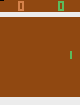

In [0]:
import imageio
from IPython.display import Image, display

last_pictures_small = []

for j in range(len(last_pictures)):
    I = last_pictures[j]
    I = I[::2,::2,:]
    last_pictures_small.append(I)

imageio.mimsave('pong_nn_big.gif', last_pictures, duration = 0.04)
imageio.mimsave('pong_nn_small.gif', last_pictures_small, duration = 0.04)

with open('pong_nn_small.gif','rb') as f:
    display(Image(data=f.read(), format='png', width=160, height=210)) #  width=160, height=210

# Copy gif files (and training checkpoint) into google Drive

Mount google Drive ('My Drive'). The last match is saved as an mp4 file and can be moved to google Drive.

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls "/content/drive/My Drive"

!ls "video/"

# Copy file
#!cp 'video/openaigym.video.0.126.video000000.mp4' '/content/drive/My Drive/openaigym.video.0.126.video000000.mp4'
#!cp 'video/openaigym.video.0.126.video000000.meta.json' '/content/drive/My Drive/openaigym.video.0.126.video000000.meta.json'

Copy the gif files it into google Drive:

In [0]:
!cp 'pong_nn_big.gif' '/content/drive/My Drive/pong_nn_big.gif'
!cp 'pong_nn_small.gif' '/content/drive/My Drive/pong_nn_small.gif'

Copy checkpoint  into google Drive to restore the trained neuronal network locally:

In [0]:
!ls "checkpoints" # policy_network.ckpt.data-00000-of-00001 might be some 100 MB large.


In [0]:
!cp 'checkpoints/checkpoint' '/content/drive/My Drive/checkpoint				 '
!cp 'checkpoints/policy_network.ckpt.index' '/content/drive/My Drive/policy_network.ckpt.index'
!cp 'checkpoints/policy_network.ckpt.meta' '/content/drive/My Drive/policy_network.ckpt.meta'
!cp 'checkpoints/policy_network.ckpt.data-00000-of-00001' '/content/drive/My Drive/policy_network.ckpt.data-00000-of-00001'